<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S9/EVA4_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import torch
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import sys
import torch.nn as nn
import os

##Mount Google Drive to get files

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!rm -rf '/content/drive/My Drive/colab_notebooks/S9/__pycache__'
!ls -lrt '/content/drive/My Drive/colab_notebooks/S9/'

total 86
-rw------- 1 root root   594 May 18 10:44 visualise_loss_acc.py
-rw------- 1 root root  1512 May 21 08:14 training.py
-rw------- 1 root root  1332 May 21 09:34 testing.py
-rw------- 1 root root  1644 May 30 18:36 train_test_loader.py
drwx------ 2 root root  4096 May 30 18:38 data
-rw------- 1 root root  4085 May 30 18:41 resnet18.py
-rw------- 1 root root   722 May 30 19:02 albumentation_transforms.py
-rw------- 1 root root  1475 May 30 21:03 get_images.py
-rw------- 1 root root  6767 May 30 21:19 gradcam.py
-rw------- 1 root root  2988 May 30 22:55 QuizDNN.py
-rw------- 1 root root 55606 May 30 23:05 acc_vs_loss.jpg
-rw------- 1 root root  5094 May 30 23:19 EVA4_S9.ipynb


##Add Google Drive path to system path

In [4]:
os.chdir('./drive/My Drive/colab_notebooks/S9/')

!ls

acc_vs_loss.jpg		     EVA4_S9.ipynb  QuizDNN.py	 training.py
albumentation_transforms.py  get_images.py  resnet18.py  train_test_loader.py
data			     gradcam.py     testing.py	 visualise_loss_acc.py


##Import python files

In [0]:
import train_test_loader as ttl
import resnet18 as bm
import training as trn
import testing as tst
import visualise_loss_acc as vis
import gradcam as gc
import get_images as gc_img

##Main Function

In [0]:
def main(classes):

  train_loader, test_loader,test_transform = ttl.get_train_test(classes)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

  model = bm.ResNet18(dropout=0.1).to(device)
  summary(model, input_size=(3, 32, 32))

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=35, gamma=0.1)
  EPOCHS=25
 
  test_loss=[]
  test_accuracy=[]
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch + 1)
      train_losses,train_acc=trn.train(model, device, train_loader, optimizer,EPOCHS,criterion,l1=1e-6,l2=1e-3)
      scheduler.step()
      test_losses,test_acc=tst.test(model, device, test_loader,criterion)

      test_loss.append(test_losses)
      test_accuracy.append(test_acc)
  
  vis.plot_acc_loss(test_loss,test_accuracy)
  
  ##gradcam##

  misclass, correct=gc_img.get_images(model,device, test_loader,batch_size=128,num_imgs=2)
  target_layers = ["layer1","layer2","layer3","layer4"]
  viz_cam = gc.VisualizeCam(model,classes, target_layers)

  num_img = len(misclass)

  incorrect_pred_imgs = []
  inc_image_for_gradcam = []
  for i in range(num_img):
    incorrect_pred_imgs.append(torch.as_tensor(misclass[i][0]))
    inc_image_for_gradcam.append(misclass[i])

  print('\n--GRADCAM FOR MISCLASSIFIED IMAGES--')
  viz_cam(torch.stack(incorrect_pred_imgs), inc_image_for_gradcam, target_layers, metric="incorrect")

##Calling Main

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
cuda


  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Loss=1.7415752410888672 Batch_id=390 Accuracy=45.93: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6010/10000 (60.10%)

EPOCH: 2


Loss=1.4966140985488892 Batch_id=390 Accuracy=64.04: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7055/10000 (70.55%)

EPOCH: 3


Loss=1.3860141038894653 Batch_id=390 Accuracy=72.11: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7428/10000 (74.28%)

EPOCH: 4


Loss=0.9512979984283447 Batch_id=390 Accuracy=76.01: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7848/10000 (78.48%)

EPOCH: 5


Loss=1.2933199405670166 Batch_id=390 Accuracy=79.03: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7653/10000 (76.53%)

EPOCH: 6


Loss=1.0197575092315674 Batch_id=390 Accuracy=81.00: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7975/10000 (79.75%)

EPOCH: 7


Loss=1.0492393970489502 Batch_id=390 Accuracy=83.17: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8053/10000 (80.53%)

EPOCH: 8


Loss=1.0173999071121216 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8404/10000 (84.04%)

EPOCH: 9


Loss=0.8378188014030457 Batch_id=390 Accuracy=85.32: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8466/10000 (84.66%)

EPOCH: 10


Loss=0.9260480403900146 Batch_id=390 Accuracy=86.21: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8343/10000 (83.43%)

EPOCH: 11


Loss=1.2018322944641113 Batch_id=390 Accuracy=87.22: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8253/10000 (82.53%)

EPOCH: 12


Loss=0.887357771396637 Batch_id=390 Accuracy=88.04: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8649/10000 (86.49%)

EPOCH: 13


Loss=0.8509657979011536 Batch_id=390 Accuracy=88.51: 100%|██████████| 391/391 [01:05<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8613/10000 (86.13%)

EPOCH: 14


Loss=0.8896624445915222 Batch_id=390 Accuracy=89.06: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8444/10000 (84.44%)

EPOCH: 15


Loss=0.7757101058959961 Batch_id=390 Accuracy=90.07: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8622/10000 (86.22%)

EPOCH: 16


Loss=0.9633703231811523 Batch_id=390 Accuracy=90.53: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8639/10000 (86.39%)

EPOCH: 17


Loss=0.8170881271362305 Batch_id=390 Accuracy=90.89: 100%|██████████| 391/391 [01:05<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8604/10000 (86.04%)

EPOCH: 18


Loss=0.873341977596283 Batch_id=390 Accuracy=91.34: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8507/10000 (85.07%)

EPOCH: 19


Loss=0.7789257764816284 Batch_id=390 Accuracy=91.89: 100%|██████████| 391/391 [01:05<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8681/10000 (86.81%)

EPOCH: 20


Loss=0.7632556557655334 Batch_id=390 Accuracy=92.06: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8628/10000 (86.28%)

EPOCH: 21


Loss=1.0672316551208496 Batch_id=390 Accuracy=92.23: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8669/10000 (86.69%)

EPOCH: 22


Loss=0.7778377532958984 Batch_id=390 Accuracy=92.68: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8833/10000 (88.33%)

EPOCH: 23


Loss=0.6871906518936157 Batch_id=390 Accuracy=92.94: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8864/10000 (88.64%)

EPOCH: 24


Loss=0.9524296522140503 Batch_id=390 Accuracy=93.54: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8827/10000 (88.27%)

EPOCH: 25


Loss=0.8301308751106262 Batch_id=390 Accuracy=93.69: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]



Test set: Average loss: 0.0037, Accuracy: 8682/10000 (86.82%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



--GRADCAM FOR MISCLASSIFIED IMAGES--


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


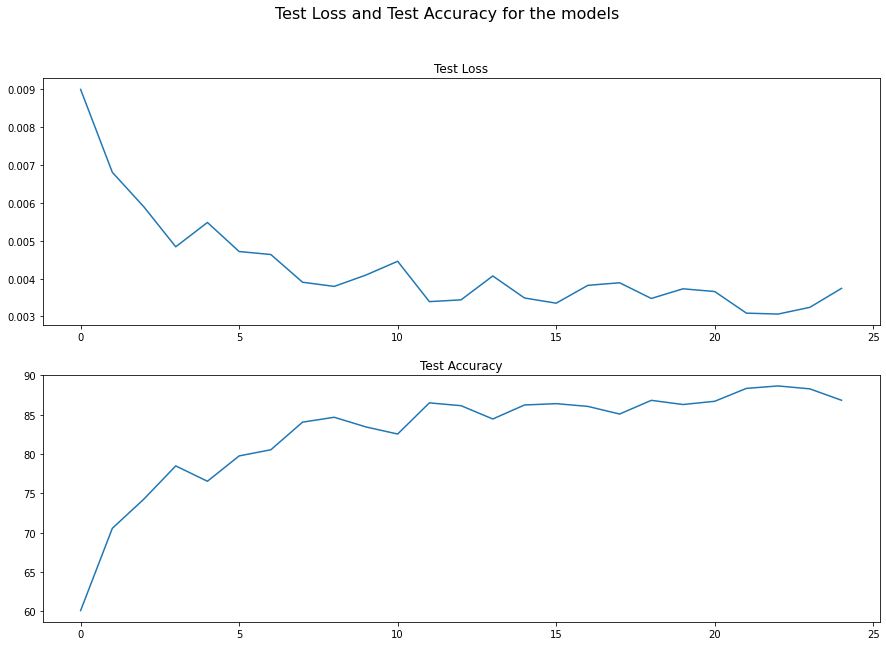

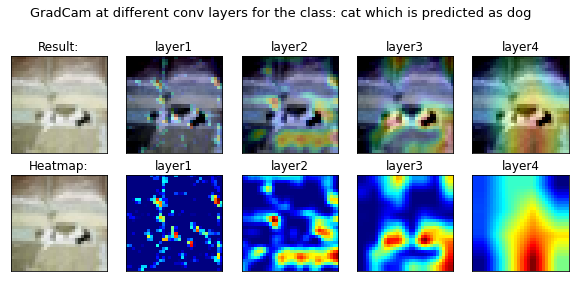

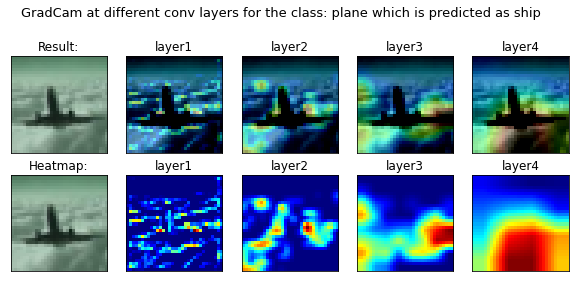

In [7]:
if __name__ == '__main__':
  from tqdm import tqdm
  if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')
  
  main(classes)